<a href="https://colab.research.google.com/github/richayanamandra/GenAI-Experiments/blob/main/genAI_lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

In [4]:
DATASET="MNIST"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor()
])

if DATASET == "MNIST":
    train_data = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
    test_data = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 19.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 510kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.32MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.82MB/s]


In [5]:
#VAE Architecture
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )

        self.mu = nn.Linear(256, latent_dim)
        self.logvar = nn.Linear(256, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu = self.mu(h)
        logvar = self.logvar(h)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar


In [6]:
#Loss Function
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [7]:
#Hyperparameter Tuning
def train_model(latent_dim, lr, epochs=10):
    model = VAE(latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x, _ in train_loader:
            x = x.view(-1, 784).to(device)

            recon, mu, logvar = model(x)
            loss = vae_loss(recon, x, mu, logvar)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

    return total_loss / len(train_loader.dataset)

In [8]:
search_space = {
    "latent": [2, 8, 16],
    "lr": [1e-3, 5e-4]
}

best_loss = float("inf")
best_params = None

for z in search_space["latent"]:
    for lr in search_space["lr"]:
        print(f"Testing latent={z}, lr={lr}")
        loss = train_model(z, lr)
        print("Loss:", loss)

        if loss < best_loss:
            best_loss = loss
            best_params = (z, lr)

print("\nBest Params:", best_params)


Testing latent=2, lr=0.001
Loss: 143.18251638997396
Testing latent=2, lr=0.0005
Loss: 145.27460891927083
Testing latent=8, lr=0.001
Loss: 107.05057700195313
Testing latent=8, lr=0.0005
Loss: 110.25306487630208
Testing latent=16, lr=0.001
Loss: 103.44448893229166
Testing latent=16, lr=0.0005
Loss: 104.70802350260416

Best Params: (16, 0.001)


In [9]:
#Train best model
latent_dim, lr = best_params
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses = []
val_losses = []

EPOCHS = 30

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0

    for x, _ in train_loader:
        x = x.view(-1, 784).to(device)
        recon, mu, logvar = model(x)

        loss = vae_loss(recon, x, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader.dataset))

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {train_losses[-1]:.4f}")


Epoch 1/30 | Loss: 175.8360
Epoch 2/30 | Loss: 127.4958
Epoch 3/30 | Loss: 117.3799
Epoch 4/30 | Loss: 112.7709
Epoch 5/30 | Loss: 110.0681
Epoch 6/30 | Loss: 108.1186
Epoch 7/30 | Loss: 106.7161
Epoch 8/30 | Loss: 105.6568
Epoch 9/30 | Loss: 104.7747
Epoch 10/30 | Loss: 103.9856
Epoch 11/30 | Loss: 103.3838
Epoch 12/30 | Loss: 102.8477
Epoch 13/30 | Loss: 102.3249
Epoch 14/30 | Loss: 101.9240
Epoch 15/30 | Loss: 101.5940
Epoch 16/30 | Loss: 101.2626
Epoch 17/30 | Loss: 100.9212
Epoch 18/30 | Loss: 100.6999
Epoch 19/30 | Loss: 100.4179
Epoch 20/30 | Loss: 100.1683
Epoch 21/30 | Loss: 99.9337
Epoch 22/30 | Loss: 99.7584
Epoch 23/30 | Loss: 99.5647
Epoch 24/30 | Loss: 99.3647
Epoch 25/30 | Loss: 99.2119
Epoch 26/30 | Loss: 99.0584
Epoch 27/30 | Loss: 98.8972
Epoch 28/30 | Loss: 98.7810
Epoch 29/30 | Loss: 98.6817
Epoch 30/30 | Loss: 98.5263


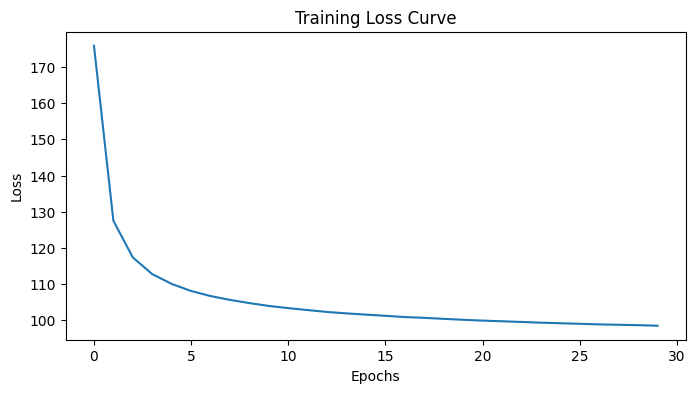

In [10]:
plt.figure(figsize=(8,4))
plt.plot(train_losses)
plt.title("Training Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


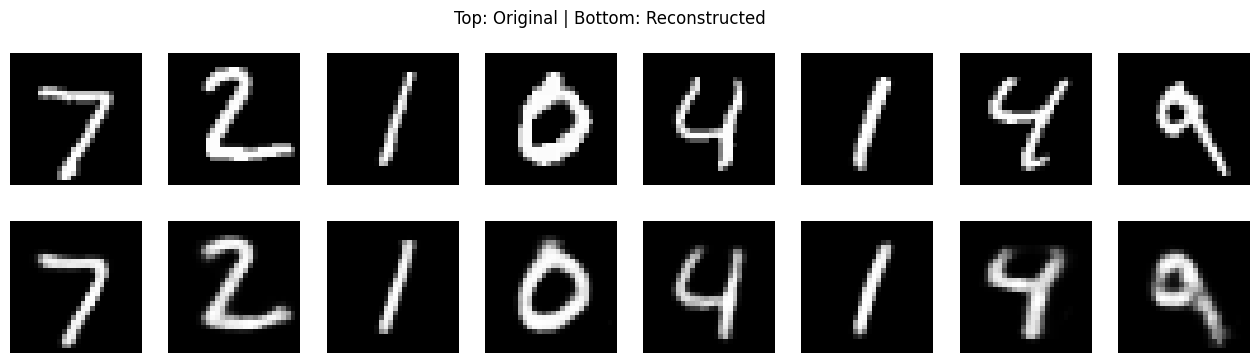

In [11]:
#Reconstruct
model.eval()
x, _ = next(iter(test_loader))
x = x.view(-1, 784).to(device)

with torch.no_grad():
    recon, _, _ = model(x)

n = 8
plt.figure(figsize=(16,4))

for i in range(n):
    # Original
    plt.subplot(2, n, i+1)
    plt.imshow(x[i].cpu().view(28,28), cmap="gray")
    plt.axis("off")

    # Reconstructed
    plt.subplot(2, n, i+n+1)
    plt.imshow(recon[i].cpu().view(28,28), cmap="gray")
    plt.axis("off")

plt.suptitle("Top: Original | Bottom: Reconstructed")
plt.show()


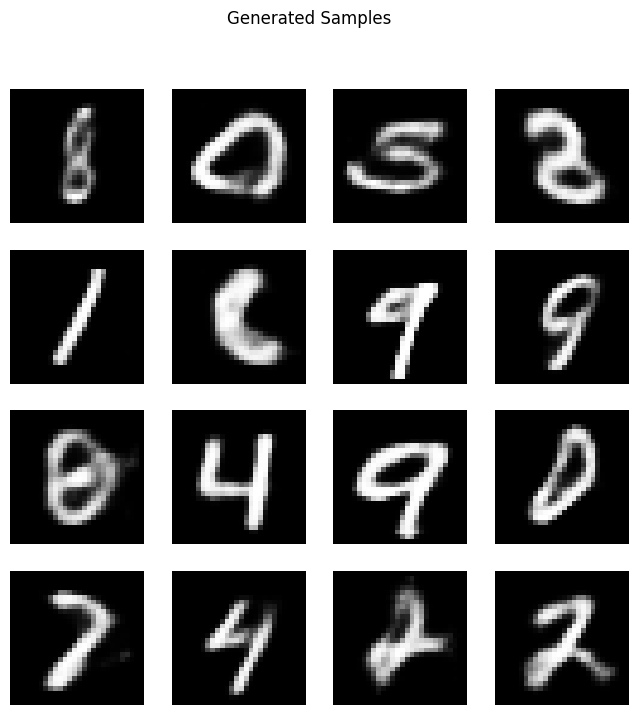

In [12]:
#Generate new samples
z = torch.randn(16, latent_dim).to(device)

with torch.no_grad():
    samples = model.decoder(z).cpu()

plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(samples[i].view(28,28), cmap="gray")
    plt.axis("off")

plt.suptitle("Generated Samples")
plt.show()


In [15]:
# Train a separate 2D latent model for visualization
latent_dim = 2
model_2d = VAE(latent_dim).to(device)
optimizer_2d = torch.optim.Adam(model_2d.parameters(), lr=1e-3)

EPOCHS_2D = 20

for epoch in range(EPOCHS_2D):
    total_loss = 0
    for x, _ in train_loader:
        x = x.view(-1, 784).to(device)

        recon, mu, logvar = model_2d(x)
        loss = vae_loss(recon, x, mu, logvar)

        optimizer_2d.zero_grad()
        loss.backward()
        optimizer_2d.step()

        total_loss += loss.item()

    print(f"[2D Model] Epoch {epoch+1}/{EPOCHS_2D} | Loss: {total_loss/len(train_loader.dataset):.2f}")


[2D Model] Epoch 1/20 | Loss: 180.95
[2D Model] Epoch 2/20 | Loss: 158.59
[2D Model] Epoch 3/20 | Loss: 153.66
[2D Model] Epoch 4/20 | Loss: 150.71
[2D Model] Epoch 5/20 | Loss: 148.75
[2D Model] Epoch 6/20 | Loss: 147.19
[2D Model] Epoch 7/20 | Loss: 145.82
[2D Model] Epoch 8/20 | Loss: 144.72
[2D Model] Epoch 9/20 | Loss: 143.93
[2D Model] Epoch 10/20 | Loss: 143.31
[2D Model] Epoch 11/20 | Loss: 142.64
[2D Model] Epoch 12/20 | Loss: 142.09
[2D Model] Epoch 13/20 | Loss: 141.51
[2D Model] Epoch 14/20 | Loss: 141.15
[2D Model] Epoch 15/20 | Loss: 140.78
[2D Model] Epoch 16/20 | Loss: 140.24
[2D Model] Epoch 17/20 | Loss: 139.92
[2D Model] Epoch 18/20 | Loss: 139.77
[2D Model] Epoch 19/20 | Loss: 139.36
[2D Model] Epoch 20/20 | Loss: 139.06


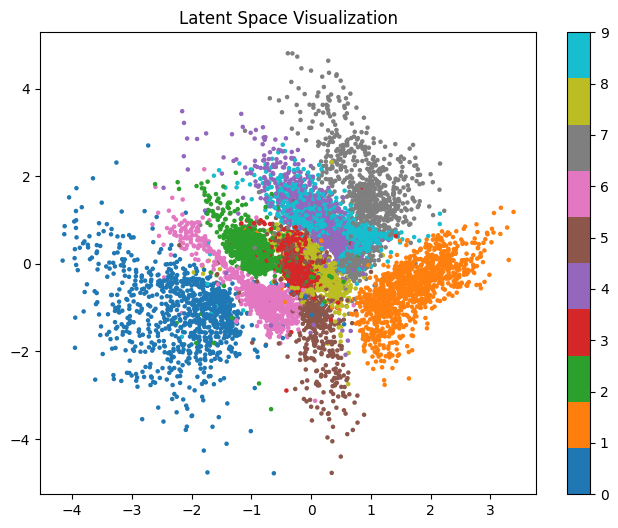

In [16]:
#Latent space visualization
if latent_dim == 2:
    latents = []
    labels = []

    model_2d.eval()
    for x, y in test_loader:
        x = x.view(-1, 784).to(device)
        with torch.no_grad():
            _, mu, _ = model_2d(x)

        latents.append(mu.cpu())
        labels.append(y)

    latents = torch.cat(latents).numpy()
    labels = torch.cat(labels).numpy()

    plt.figure(figsize=(8,6))
    scatter = plt.scatter(latents[:,0], latents[:,1], c=labels, cmap="tab10", s=5)
    plt.colorbar(scatter)
    plt.title("Latent Space Visualization")
    plt.show()